In [2]:
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import joblib
from scipy.sparse import hstack
from scipy.sparse import save_npz,load_npz

from wordcloud import WordCloud

from sklearn.feature_selection import chi2,SelectKBest
from scipy.stats import chi2_contingency


In [2]:
# Set up memory caching
memory = joblib.Memory('./cachedir', verbose=0)

## Given:
### [Real or Fake] : Fake Job Description Prediction
### This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Goal:

Process the dataset to prepare features for a classification model that predicts whether job descriptions are fraudulent or real.

## Load the data

In [3]:
@memory.cache
def load_data():
    return pd.read_csv("../data/raw/fake_job_postings.csv", index_col=0)

# Load the DataFrame (will use cache if available)
df = load_data()

## Explore the data

### Show some rows

In [4]:
# Display the first two rows
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [5]:
df[df['fraudulent']==1].head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1


### Show info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

### Assess Dataset Balance

Evaluate distribution of 'fraudulent' labels in percentage

In [7]:
df['fraudulent'].value_counts(normalize=True)*100

fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64

### Show the number of unique values in each column of the DataFrame

Helps to decide how to treat data: as binary, categorical or text

In [8]:
df.nunique().sort_values()

has_company_logo           2
has_questions              2
telecommuting              2
fraudulent                 2
employment_type            5
required_experience        7
required_education        13
function                  37
industry                 131
salary_range             874
department              1337
company_profile         1709
location                3105
benefits                6204
title                  11231
requirements           11967
description            14801
dtype: int64

### Show unique values and counts in a {column}

In [9]:
def show_top_unique_value_counts(column, ascending=False, N=20):
    data = df[column].value_counts().sort_values(ascending=ascending).head(N)

    # Display Series with index stripped to 80 characters
    padded_index = data.index.to_series().str.slice(0,80)
    display_df = pd.DataFrame(data.values, index=padded_index)
    return display_df

show_top_unique_value_counts('employment_type', ascending=False, N=15)

,0
employment_type,
Full-time,11620
Contract,1524
Part-time,797
Temporary,241
Other,227


### Visual Exploration

#### Heatmap for {column} vs Fraudulent Jobs


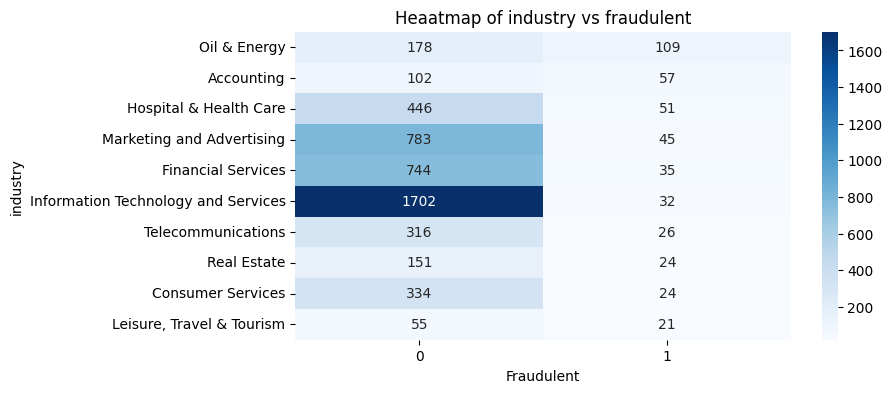

In [10]:
def show_heatmap(column, target, N = 10):
    plt.figure(figsize=(8, 4))

    # create the pivot table
    pivot_table = df.groupby([column, target]).size().unstack(fill_value=0)

    # sort the pivot table by the sum of the counts across the columns (0 and 1)
    pivot_table = pivot_table.sort_values(by=1, ascending=False)  # Sort by fraudulent jobs (1)

    # filter to include only the top N categories
    top_categories = pivot_table.index[:N]
    pivot_table = pivot_table.loc[top_categories]

    # create the heatmap
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Heaatmap of {column} vs {target}')
    plt.xlabel('Fraudulent')
    plt.ylabel(column)
    plt.show()

show_heatmap('industry', 'fraudulent')



#### Count Plot of {column} Distribution by Fraudulent Status

This shows the count of {column} for fraudulent and non-fraudulent postings.


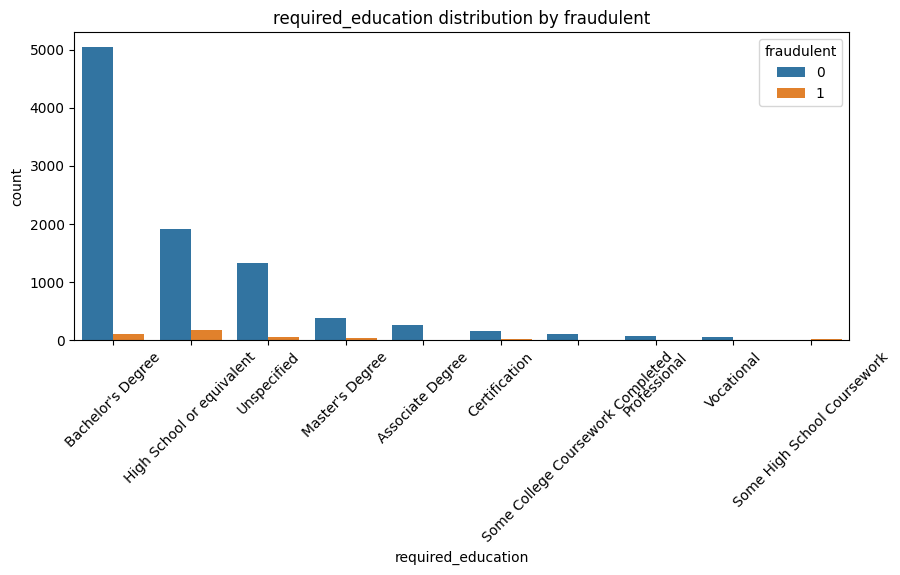

In [11]:
def show_countplot(column, N=10):
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=column, hue='fraudulent', order=df[column].value_counts().index[:N])
    plt.title(f'{column} distribution by fraudulent')
    plt.xticks(rotation=45)
    plt.show()

show_countplot('required_education')


#### Word Cloud

A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance in the source text.

Word cloud is used with textual data to visualize the most common words.

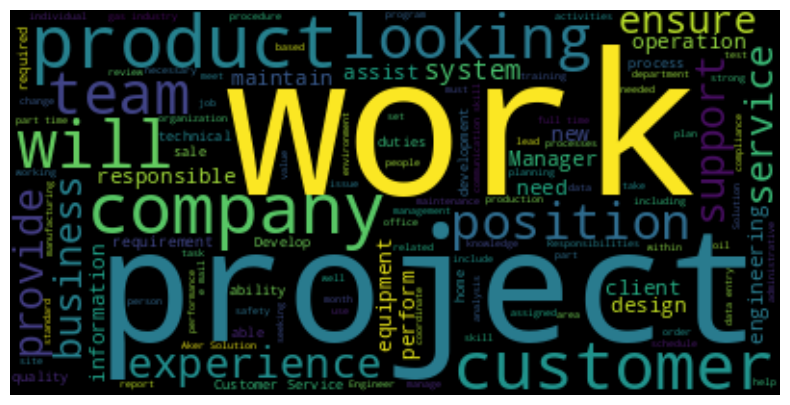

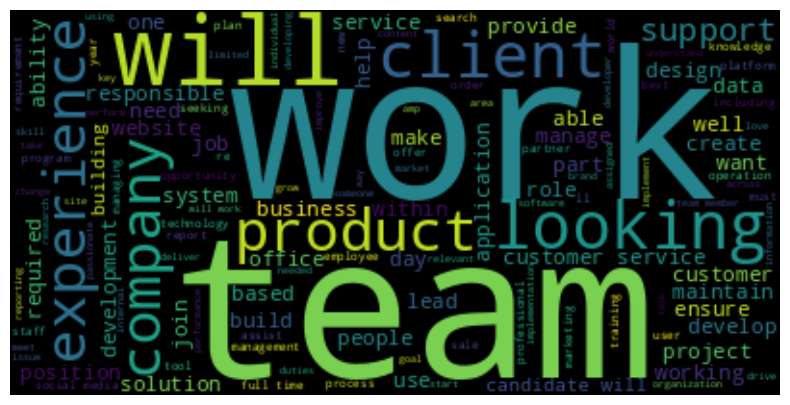

In [12]:
### Word cloud for fraudulent jobs:
@memory.cache
def generate_wordcloud(df, fraudulent=1):
    # Fill NaN values with an empty string and convert all descriptions to string
    descriptions = df[df['fraudulent'] == fraudulent]['description'].fillna('').astype(str)

    # Generate the word cloud
    wordcloud = WordCloud().generate(' '.join(descriptions))

    return wordcloud

def show_wordcloud(wordcloud):
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate and show word clouds
wordcloud_fraudulent = generate_wordcloud(df, fraudulent=1)
wordcloud_non_fraudulent = generate_wordcloud(df, fraudulent=0)

show_wordcloud(wordcloud_fraudulent)
show_wordcloud(wordcloud_non_fraudulent)

## Clean and Handle Missing Values

- Drop columns with a high percentage of missing values.
- Drop rows based on the importance of the columns and the amount of missing data.
- For categorical data: fill missing values with a placeholder or the mode.
- For text data: fill missing values with a placeholder or an empty string (`''`).
- Clean string data: remove special characters and convert to lowercase.

Notes:

- As the dataset is very imbalanced (95.16% for 0 and 4.84% for 1), we will apply rows removal only for the majority class (0).

- Conduct data imputation with mean, mode and etc. **after** train/test split in order to prevent data leakage, ensuring that information from the test set does not influence the training process.

### Drop rows/cols

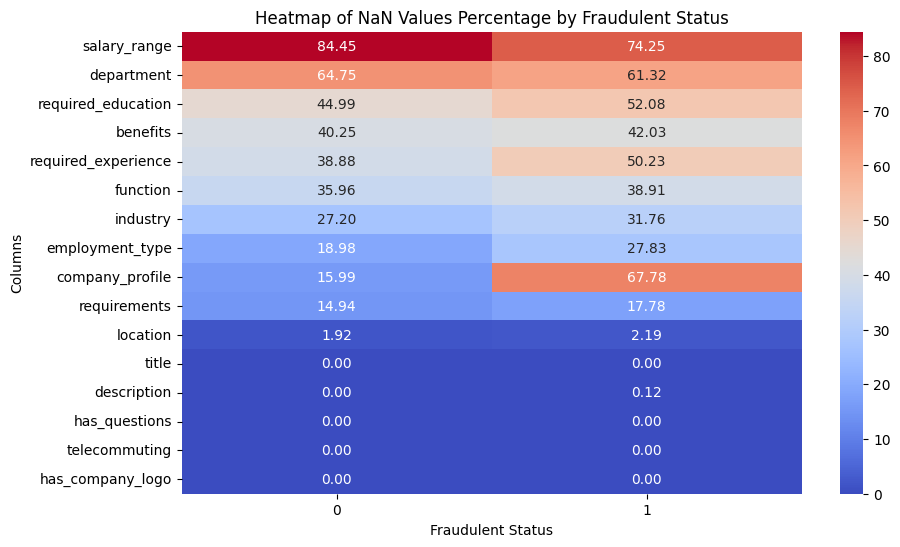

In [13]:
# Check for NaN values (in percentage) grouped by 'fraudulent' and sort the counts
nan_percentage = df.groupby('fraudulent').apply(
    lambda group: group.isna().mean()*100, include_groups=False
).T.sort_values(by=0, ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(nan_percentage, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of NaN Values Percentage by Fraudulent Status')
plt.xlabel('Fraudulent Status')
plt.ylabel('Columns')
plt.show()

In [14]:
# Drop columns with a high percentage of missing values in both classes
df.drop(columns=['salary_range', 'department'], inplace=True)

In [15]:
# drop rows with missing 'description'
df.dropna(subset=['description'], inplace=True)

### Feature Engineering: create a binary feature for 'company_profile'

The 'company_profile' column has significantly more NaN values in fraudulent samples compared to non-fraudulent ones. The absence of a company profile may be a strong indicator of fraudulence.

In [16]:
# Create a binary feature: 1 (True) if 'company_profile' exists, 0 if it's NaN
df['has_company_profile'] = df['company_profile'].notna().astype(int)


### Clean text and categorical data

- Remove special characters.
- Convert to lowercase.

In [17]:
# Define a function to clean the text
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Trim leading and trailing spaces
        text = text.strip()
        # Collapse multiple spaces into a single space
        text = re.sub(r'\s+', ' ', text)
        return text
    return text

# Select columns with 'object' dtype
string_columns = df.select_dtypes(include=['object']).columns

# Apply the function to all object columns
df[string_columns] = df[string_columns].apply(clean_text)


### Impute Missing Values

We will impute missing values using placeholders instead of mode or other value-dependent approaches. This allows us to perform imputation before the data split.

In [ ]:
missing_values_columns = df.columns[df.isna().sum() != 0].tolist()
missing_values_columns

['location',
 'company_profile',
 'requirements',
 'benefits',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [19]:
show_top_unique_value_counts('function', 10)

,0
function,
Science,14
Purchasing,15
Distribution,24
Financial Analyst,33
Supply Chain,36
Training,38
Strategy/Planning,46
Legal,47
Research,50


In [20]:
# Impute categorical and text columns with placeholders
placeholder_map = {
    'location': 'Other',
    'company_profile': 'Missing',
    'requirements': 'Missing',
    'benefits':'See job description', # mode
    'employment_type':'Other',
    'required_experience': 'Not Applicable',
    'required_education':'Unspecified',
    'industry':'Other',
    'function': 'Other'
}

df.fillna(value=placeholder_map, inplace=True)

In [ ]:
# Check for missing values again
df.isna().sum().sum()

np.int64(0)

### Identify Data Types

Identifying columns as binary, categorical or text is essential to be made in the beginning, because:
- Categorical variables often need to be encoded into numerical formats (e.g., one-hot encoding, label encoding) for machine learning algorithms, while text data typically requires different processing techniques, such as tokenization or vectorization.
- Different strategies are often employed for imputing missing values depending on whether a column is categorical or textual.

In [22]:
# check unique values - helps to decide how to treat data: as binary, categorical or text
df.nunique().sort_values()

telecommuting              2
has_company_logo           2
has_company_profile        2
has_questions              2
fraudulent                 2
employment_type            5
required_experience        7
required_education        13
function                  37
industry                 132
company_profile         1710
location                3106
benefits                6204
title                  11231
requirements           11968
description            14801
dtype: int64

In [23]:
show_top_unique_value_counts(column='title',ascending=False, N=10)

,0
title,
English Teacher Abroad,311
Customer Service Associate,146
Graduates: English Teacher Abroad (Conversational),144
English Teacher Abroad,95
Software Engineer,86
English Teacher Abroad (Conversational),83
Customer Service Associate - Part Time,76
Account Manager,75
Web Developer,66


In [24]:
binary_columns = [
    'has_company_logo',
    'has_questions',
    'telecommuting',
    'fraudulent',
]

ordinal_columns = [
    'employment_type',
    'required_experience',
    'required_education',
]

nominal_columns = [
    'function',
    'industry',
    'location',
    'benefits',
]

text_columns = [
    'company_profile',
    'title',
    'requirements',
    'description'
]

## Feature Selection

### Explore Feature Importance

To assess the relationship between each potential feature and the target variable we can use techniques like Chi-Squared Test for categorical features and ANOVA for numerical features

In [25]:
chi2_results = []

# Perform Chi-Squared test for each categorical feature
for feature in text_columns+nominal_columns+ordinal_columns:
    contingency_table = pd.crosstab(df[feature], df['fraudulent'])
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2_stat, p_val))

# Convert results to DataFrame for better readability
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2 Stat', 'P-Value'])

# Sort by Chi-Squared statistic
chi2_df.sort_values(by='Chi2 Stat', ascending=False, inplace=True)
chi2_df


,Feature,Chi2 Stat,P-Value
3,description,17864.519864,4.963654e-63
1,title,16131.599406,8.776728e-184
2,requirements,14631.992609,1.366133e-58
7,benefits,10236.907164,7.475361e-204
6,location,8403.198776,0.000000e+00
0,company_profile,7406.367212,0.000000e+00
5,industry,1624.674673,8.151116e-256
4,function,532.693937,1.089057e-89
10,required_education,460.354467,5.969304e-91
9,required_experience,124.974127,1.467782e-24


#### Interpretation

1. Chi-Squared Statistic (Chi2 Stat): A number showing how strongly a feature is related to the target. Higher numbers mean a stronger connection. For example, description and title have the highest scores, meaning they are very good candidates for predicting whether a job is fake.

1. P-Value: A number that tells you how likely it is that the observed relationship happened by chance. A smaller p-value (less than 0.05) means the connection is likely real and not just random chance. Description and title have extremely low p-values, so we can be confident these features are important.


We will select the top 4 features that have the highest Chi2 score (all features have p-value < 0.05)

In [26]:
feature_names = chi2_df.iloc[:4,0]
feature_names

3     description
1           title
2    requirements
7        benefits
Name: Feature, dtype: object

In [27]:
# ['description', 'company_profile', 'title', 'requirements']
X = df[feature_names]
y = df['fraudulent']

## Encode Categorical Variables:

Apply appropriate encoding techniques:
- **Binary columns**: Use direct mapping (0/1).
- **Ordinal columns**: Use Label Encoding. If we want to to ensure the encoding respects the order of the categories we can use Ordinal Encoding. 
- **Nominal columns**: Use One-Hot Encoding, Target encoding or Frequency encoding 

In [28]:
df[binary_columns].dtypes

has_company_logo    int64
has_questions       int64
telecommuting       int64
fraudulent          int64
dtype: object

### Encode Ordinal columns 

We will use the Ordinal Encoder, but will not specify the order of the categories, let it use the default (alphabetical) order.

In [29]:
ordinal_encoder = OrdinalEncoder()
df[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])

### Encode Nominal columns

We will use the Frequency Encoder - will replace the original categorical values in the DataFrame with their corresponding frequencies. 

In [30]:
def frequency_encode(df, nominal_columns):
    for column in nominal_columns:
        # Calculate frequency of each category
        frequency = df[column].value_counts() / len(df)
        # Map frequencies to the column
        df[column] = df[column].map(frequency)
    return df

df = frequency_encode(df, nominal_columns)

In [31]:
df.head(2)

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_company_profile
job_id,,,,,,,,,,,,,,,,
1,Marketing Intern,0.036803,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0.443929,0,1,0,2.0,4.0,9.0,0.274176,0.046423,0,1
2,Customer Service - Cloud Video Production,0.000503,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0.000056,0,1,0,1.0,6.0,9.0,0.046311,0.068740,0,1


## Split the Data

In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
print(X_train.shape)
print(X_test.shape)

(14303, 4)
(3576, 4)


## Encode text data into TF-IDF vectors

In [41]:
feature_names

3     description
1           title
2    requirements
7        benefits
Name: Feature, dtype: object

In [34]:
# Define the TF-IDF vectorization function
@memory.cache
def fit_and_transform_tfidf(X_train_raw, X_test_raw, features):
    # Initialize vectorizers for each text feature
    vectorizers = {
        feature: TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 2))
        for feature in features
    }

    # List to store TF-IDF matrices
    tfidf_matrices_train = []
    tfidf_matrices_test = []

    # Loop through features to fit and transform
    for feature in features:
        # Fit on training data and transform both train and test data
        vectorizers[feature].fit(X_train_raw[feature])
        tfidf_matrix_train = vectorizers[feature].transform(X_train_raw[feature])
        tfidf_matrix_test = vectorizers[feature].transform(X_test_raw[feature])

        tfidf_matrices_train.append(tfidf_matrix_train)
        tfidf_matrices_test.append(tfidf_matrix_test)

    # Combine all TF-IDF matrices into one
    X_train = hstack(tfidf_matrices_train)
    X_test = hstack(tfidf_matrices_test)

    return X_train, X_test, vectorizers


# Fit and transform the TF-IDF vectors (this will be cached)
X_train_encoded, X_test_encoded, vectorizers = fit_and_transform_tfidf(X_train, X_test, feature_names)

# Save vectorizer for each feature
vectorizers_path = '../models/vectorizers/'
if not os.path.exists(vectorizers_path):
    os.makedirs(vectorizers_path)

for feature in feature_names:
    joblib.dump(vectorizers[feature], f'{vectorizers_path}tfidf_vectorizer_{feature}.pkl')


In [35]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(14303, 115401)
(3576, 115401)


## Balance the dataset

In [36]:
# check for imbalaced dataset - calculate percentages:
y_train_counts = y_train.value_counts()
percentages = (y_train_counts/y_train_counts.sum())*100
percentages

fraudulent
0    95.161854
1     4.838146
Name: count, dtype: float64

In [4]:
# Creating an instance of SMOTE
smote = SMOTE()

# Balancing the data
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

print(X_resampled.shape)
print(y_resampled.shape)

NameError: name 'X_train_encoded' is not defined

## Save processed data

In [3]:
# path to save the processed data
path = '../data/processed/'
# create folder if it doesn't exist
if not os.path.exists(path):
    os.makedirs(path)

# Save X_train and X_test resampled as a sparse matrix
save_npz(path+'X_resampled.npz', X_resampled)
save_npz(path+'X_test.npz', X_resampled)

# Save y_resampled as numpy array
np.save(path+'y_resampled.npy', y_resampled)
np.save(path+'y_test.npy', y_resampled)


NameError: name 'X_resampled' is not defined

##  Load processed data

In [39]:
# Load the X sparse matrix
X_resampled_loaded = load_npz(path+'X_resampled.npz')

# Load the y target variable
y_resampled_loaded = np.load(path+'y_resampled.npy')

In [40]:
print(X_resampled_loaded.shape)
print(y_resampled_loaded.shape)

(27222, 115401)
(27222,)
